In [2]:
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

import monai
from monai import transforms

from utils.utils import adjust_window, visualize, print_info

In [3]:
data_dict = {
    'image': '../data/ID_c9d6fdc6_ID_7f09be285d.nii.gz',
    'label': '../data/ID_c9d6fdc6_ID_7f09be285d-ich_seg.nii.gz'
}

In [4]:
# 数据读取
io_transform = transforms.LoadImaged(keys=["image", "label"])
data = io_transform(data_dict)
print_info(data)

image shape: torch.Size([512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


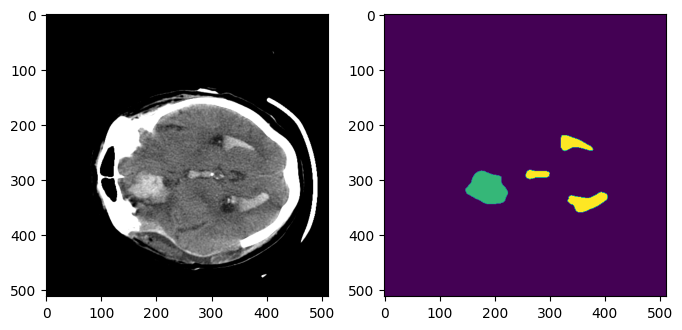

In [5]:
visualize(data)

In [6]:
# 添加channel维度
transform = transforms.EnsureChannelFirstd(keys=["image", "label"])
add_data = transform(data)
print_info(add_data)

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


In [7]:
# 数据保存
transform = transforms.SaveImaged(keys=["image", "label"], output_dir="output", output_ext=".nii.gz", separate_folder=False)
aug_data = transform(data)
print_info(aug_data)

2025-05-19 16:47:10,340 INFO image_writer.py:197 - writing: output\ID_c9d6fdc6_ID_7f09be285d_trans.nii.gz
2025-05-19 16:47:11,171 INFO image_writer.py:197 - writing: output\ID_c9d6fdc6_ID_7f09be285d-ich_seg_trans.nii.gz
image shape: torch.Size([512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


## SpatialPad

`SpatialPad` 是 MONAI（Medical Open Network for AI）中用于医学图像预处理的数据增强工具之一，主要用于将图像或标签填充到指定的空间大小，常用于训练时保证图像输入的一致性，尤其是批处理操作时。

### 使用场景 


- 图像尺寸不一致时，对齐输入尺寸。

- 模型需要固定大小输入时，自动填充图像边界。

- 适用于 2D/3D 医学图像（如 CT/MRI）。

### 参数解析 

| 参数         | 类型                      | 含义                                                         |
| ------------ | ------------------------- | ------------------------------------------------------------ |
| spatial_size | Union[Sequence[int], int] | 填充后的目标空间大小。如果目标大小小于原始大小，则不改变原图大小。 |
| method       | str                       | 填充方式，可选：'symmetric', 'end', 'start'。                |
| mode         | str                       | 填充模式，如 NumPy 的 np.pad()。可选：'constant', 'edge', 'reflect', 'wrap' 等。 |


填充方法对比 (`method` 参数)

| 方法名      | 描述                     |
| ----------- | ------------------------ |
| 'symmetric' | 前后填充相同量，中心对齐 |
| 'end'       | 只在后面填充             |



image shape: torch.Size([1, 768, 768, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 768, 768, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


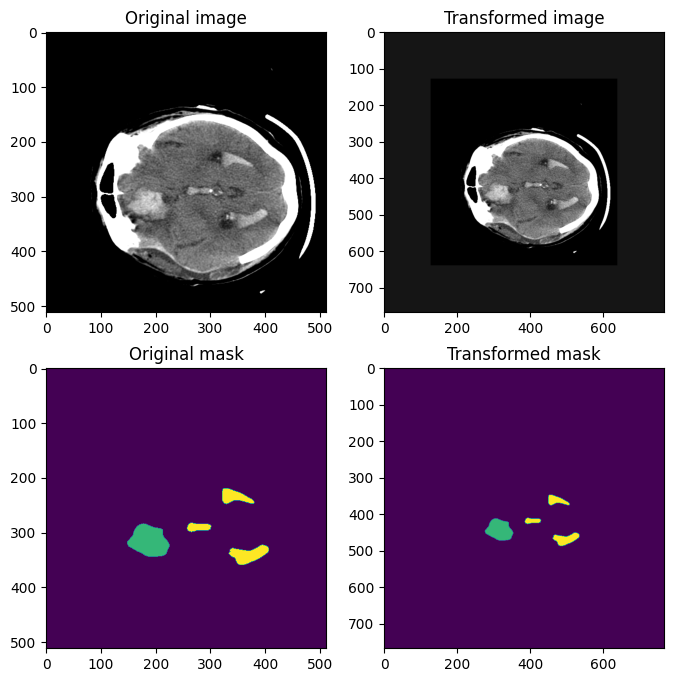

In [8]:
# 将数据pad至指定spatial_size
# - 输入为3D数据，需增强channel维度，即输入[C, H, W, D], spatial_size = [h, w, d]
# - 输入为2D数据，即输入[C, H, W], spatial_size = [h, w]
transform = transforms.SpatialPadd(keys=["image", "label"], spatial_size=[768, 768, 38])

aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## BorderPad

`BorderPad` 是一种用于医学图像处理的数据预处理/增强操作。它的主要作用是：通过在图像边缘添加一定数量的像素（padding），以满足特定尺寸需求或防止某些操作（如卷积或裁剪）引入边界伪影。

### 使用场景 


- **模型输入对齐** ：某些模型需要特定的输入大小，BorderPad 可以先 pad 再 crop。

- **防止边缘伪影** ：对小图像进行卷积、旋转、缩放等操作时可能导致边缘信息缺失，用 BorderPad 增加边界空间。

- 适用于 2D/3D 医学图像（如 CT/MRI）。

### 参数解析 

| 参数名         | 类型          | 说明                                                         |
| -------------- | ------------- | ------------------------------------------------------------ |
| spatial_border | Sequence[int] | 每个空间维度（如 H, W, D）两侧的 padding 像素数。如果为单个 int，则两边一样。 |
| mode           | str           | padding 的模式，常见的有："constant", "reflect", "replicate", "circular" 等。 |




image shape: torch.Size([1, 576, 576, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 576, 576, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


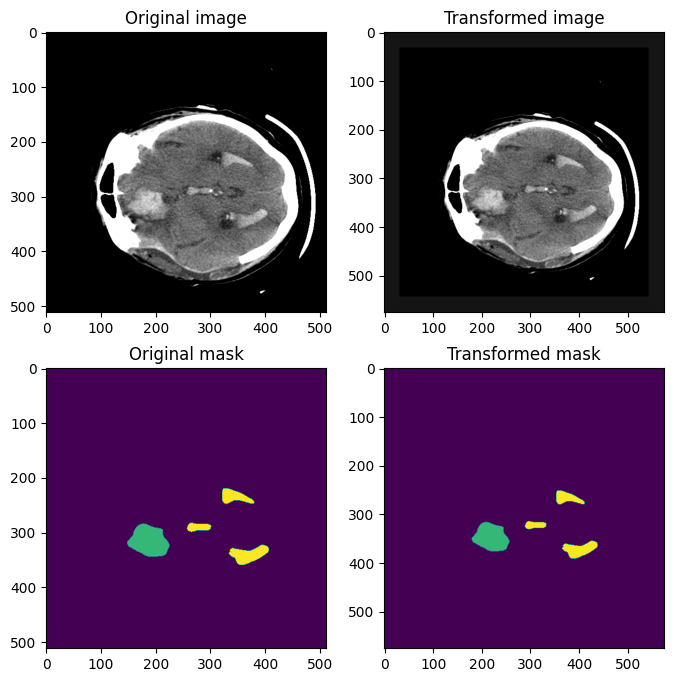

In [9]:
transform = transforms.BorderPadd(keys=["image", "label"], spatial_border=[32, 32, 0])
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## DivisiblePad

`DivisiblePadd` 是一种常用的图像预处理/增强操作，主要用于将图像在各个维度上填充到指定的倍数大小。这对于深度学习模型（特别是使用 U-Net 等结构）非常重要，因为很多模型要求输入尺寸能够被某个数整除（如 16 或 32）。

### 使用场景 


- 输入尺寸不规则但模型要求特定倍数的尺寸

- 对于 Patch-based 推理（如 sliding window）特别重要

- 避免在网络中因尺寸不匹配造成的 shape mismatch 错误

### 参数解析 

- **k** ：要求图像的每个空间维度（如 H、W、D）要填充到的倍数。例如，k=32 表示图像尺寸会被填充到能被 32 整除。

- **mode** ：填充方式（传递给 `np.pad` 或 `torch.nn.functional.pad`），常见的有：

    - `"constant"`：使用常数填充（通常是 0）

    - `"reflect"`：镜像填充

    - `"replicate"`：边缘复制

- **method** ：如何计算填充值的位置：

    - `"symmetric"`：左右/上下对称填充

    - `"end"`：仅在图像的结尾方向填充

- **value** ：常数填充值，仅在 mode 为 "constant" 时有效。




image shape: torch.Size([1, 512, 512, 64]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 64]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


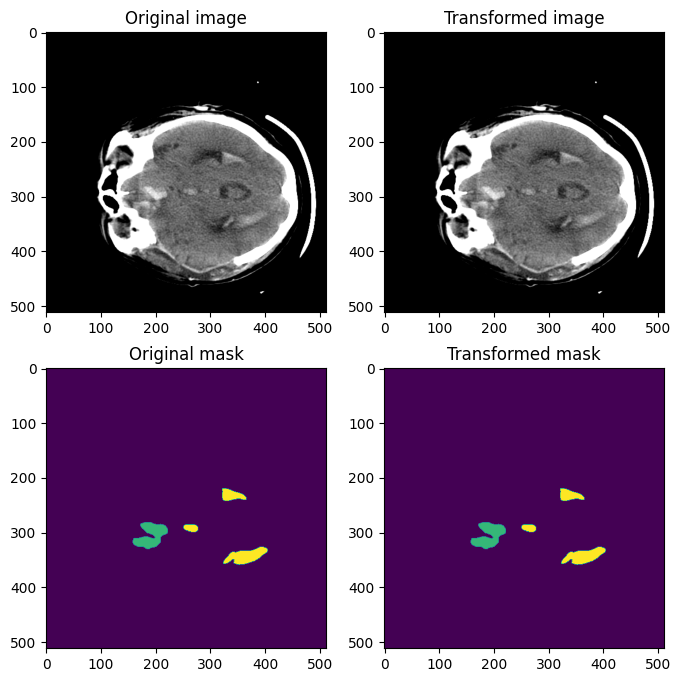

In [10]:
transform = transforms.DivisiblePadd(keys=["image", "label"], k=32)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data, ori_idx=19, aug_idx=32)

## SpatialCrop

`SpatialCropd` 用于从输入图像中按指定的空间维度和起始位置裁剪一个区域。

### 使用场景 


- 提取感兴趣区域（ROI）以减小计算负担

### 参数解析 

- `roi_start`：裁剪区域的起始坐标。

- `roi_end`：裁剪区域的结束坐标（可选）。

- `roi_center`：裁剪区域的中心点（可选）。

- `roi_size`：裁剪区域的大小（可选）。

⚠️ `roi_start + roi_size` 与 `roi_e` 是互斥使用的，不能同时指定。




image shape: torch.Size([1, 452, 452, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 452, 452, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


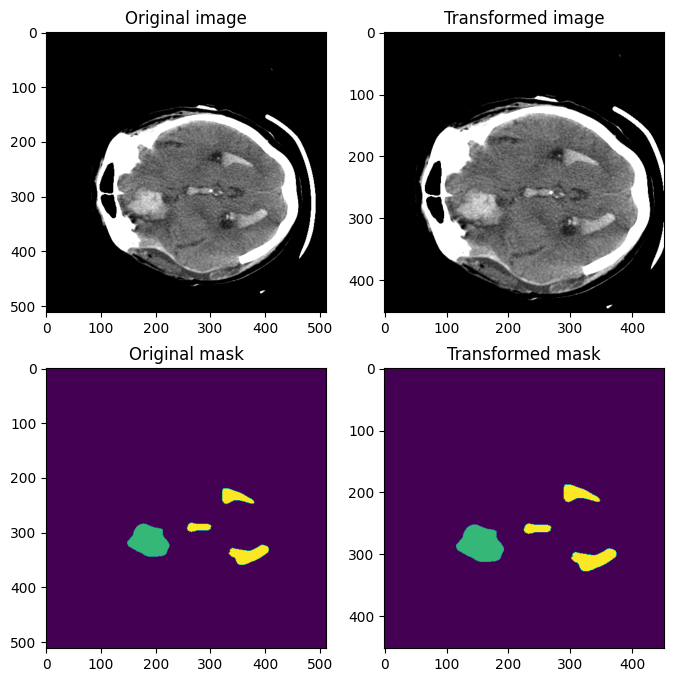

In [11]:
transform = transforms.SpatialCropd(
    keys=["image", "label"],
    roi_center=[256, 256, 19],
    roi_size=[384, 384, 38]
)

transform = transforms.SpatialCropd(
    keys=["image", "label"],
    roi_start=[32, 32, 0],
    roi_end=[484, 484, 38]
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## CenterSpatialCrop

`CenterSpatialCropd` 会以图像的中心为参考点，在空间维度上（通常是 2D 或 3D）裁剪出一个指定大小的区域。这对于医学图像中感兴趣区域往往位于中心的情况尤其有用。

### 使用场景 


- 用于统一图像大小（尤其在数据集中图像大小不一致时）
- 用于提取中心区域的局部信息（医学图像中通常包含器官或病灶）

### 参数解析 

- `roi_size`: list[int] or tuple

    - 指定裁剪区域的空间大小。例如 `[128, 128, 64]` 表示裁剪出一个大小为 128×128×64 的三维子区域。

    - 注意：这个尺寸必须小于或等于原始图像的大小，否则不会进行裁剪。




image shape: torch.Size([1, 384, 384, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 384, 384, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


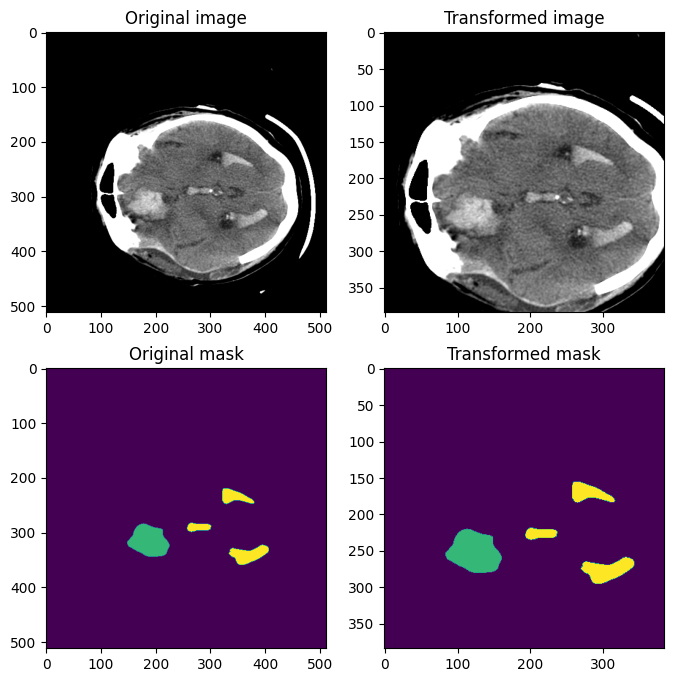

In [12]:
transform = transforms.CenterSpatialCropd(
    keys=["image", "label"],
    roi_size=[384, 384, 38]
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## CenterScaleCrop

`CenterScaleCropd` 结合了图像中心缩放（CenterScale）和裁剪（Crop）操作，常用于保持关键区域（如器官或病灶）居中，同时调整图像尺寸。该变换用于将图像按照给定的 `roi_scale` 围绕图像中心。`。

### 使用场景 


- CT/MRI 图像预处理，特别是关心中心区域的任务（如脑、肺、肝分割）

### 参数解析 

- `roi_scale`: 缩放系数。例如 `0.75` 表示在中心附近保留 8 128, 64)`。




image shape: torch.Size([1, 308, 308, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 308, 308, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


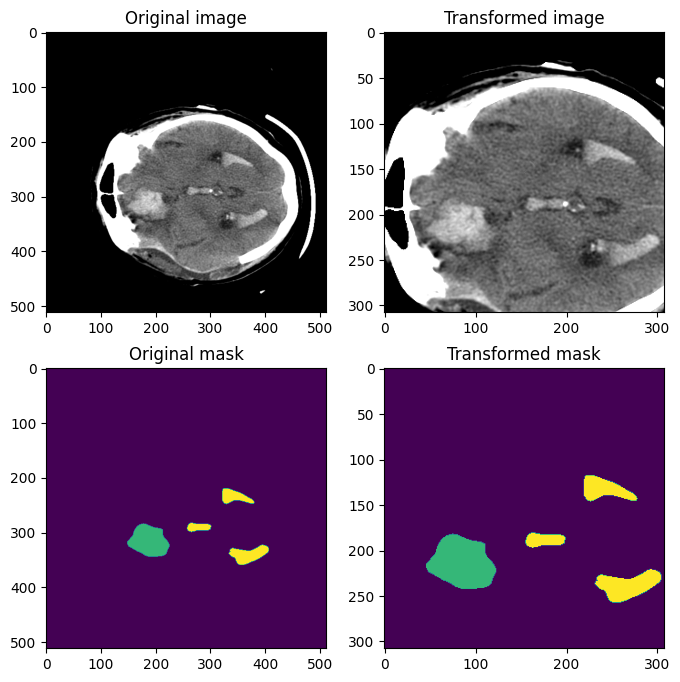

In [14]:
transform = transforms.CenterScaleCropd(
    keys=["image", "label"],
    roi_scale=[0.6, 0.6, 1],
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## RandSpatialCrop

`RandSpatialCropd` 的作用是从输入图像中随机裁剪出一个指定大小/某一范围内（ROI size，Region of Interest）的子区域（patch）。

### 使用场景 


- 图像裁剪

### 参数解析 

| 参数名        | 类型                    | 说明                                                         |
| ------------- | ----------------------- | ------------------------------------------------------------ |
| roi_size      | Sequence[int]           | 如果 random_size=False，则为固定输出大小；如果 random_size=True，它是裁剪的最小尺寸 |
| max_roi_size  | Optional[Sequence[int]] | 若 random_size=True，为最大随机裁剪尺寸（上界）；若为 None，则默认使用图像原始尺寸为上界 |
| random_center | bool                    | 是否随机裁剪中心点                                           |
| random_size   | bool                    | 是否随机裁剪尺寸。True 表示在 [roi_size, max_roi_size] 范围内随机裁剪；False 表示固定大小裁剪 |




image shape: torch.Size([1, 300, 281, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 300, 281, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


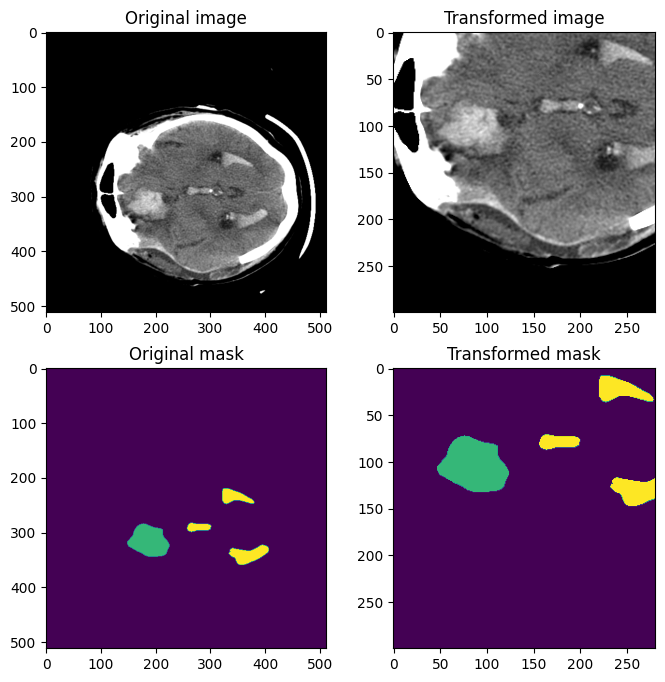

In [16]:
transform = transforms.RandSpatialCropd(
    keys=["image", "label"],
    roi_size=[224, 224, 38],
    max_roi_size=[512, 512, 38],
    random_center=True,
    random_size=True
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## RandScaleCrop

`RandSpatialCropd` 的作用是从输入图像中随机缩放出一个指定scale/某一范围内（ROI size，Region of Interest）的子区域（patch）。

### 使用场景 


- 用于训练阶段，增强样本多样性
- 减少模型对图像固定尺寸和位置的依赖
- 在有限数据集上提升模型泛化能力

### 参数解析 

| 参数          | 类型                 | 说明                                                         |
| ------------- | -------------------- | ------------------------------------------------------------ |
| roi_scale     | float or list[float] | 指定裁剪区域相对于输入图像大小的比例（scale）。行为取决于 random_size 的值（见下方详解）。 |
| max_roi_scale | float or list[float] | 与 roi_scale 一起使用，仅在 random_size=True 时有效，用来限定裁剪尺寸的最大比例。 |
| random_center | bool                 | 是否随机选择裁剪区域的中心点；若为 False，则使用图像中心。   |
| random_size   | bool                 | 是否使用随机大小进行裁剪。如果为 False，裁剪尺寸为 roi_scale * 图像尺寸；如果为 True，会在 [roi_scale, max_roi_scale] 范围内随机采样实际缩放尺寸。 |

image shape: torch.Size([1, 300, 220, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 300, 220, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


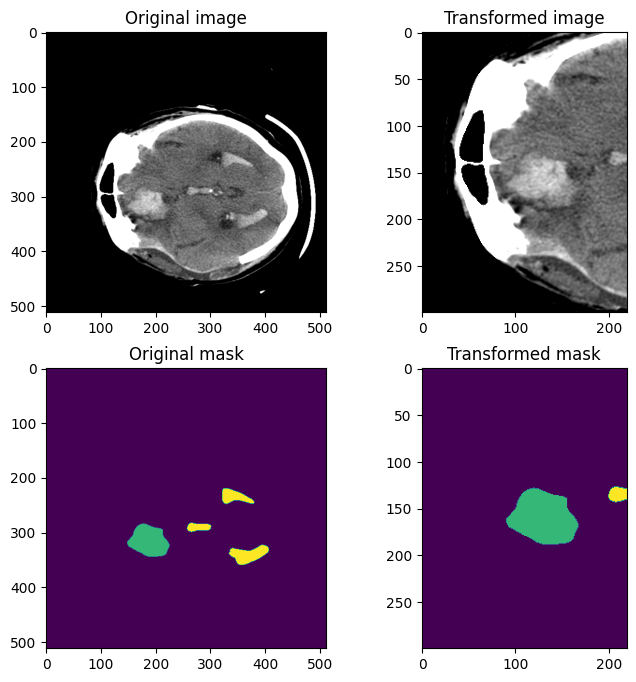

In [17]:
transform = transforms.RandScaleCropd(
    keys=["image", "label"],
    roi_scale=[0.3, 0.3, 1],
    max_roi_scale=[1, 1, 1],
    random_center=True,
    random_size=True
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## RandSpatialCropSamples

`RandSpatialCropSamplesd` 会从输入图像中随机裁剪出多个子区域（patches），通常用于训练数据增强。这些裁剪是沿空间维度进行的，比如在 3D 图像中沿着 (H, W, D)。

### 使用场景 


- 适合与 `Dataset` 或 `CacheDataset` 一起使用。
- 多个 patch 输出适用于多个实例训练（如将多个 patch 扔入 batch）。

### 参数解析 

| 参数名        | 类型                    | 说明                                                         |
| ------------- | ----------------------- | ------------------------------------------------------------ |
| roi_size      | Sequence[int]           | 如果 random_size=False，则为固定输出大小；如果 random_size=True，它是裁剪的最小尺寸 |
| num_samples   | int                     | 从输入图像中随机生成的裁剪区域数量（patch 数）。输出是一个包含多个裁剪结果的列表。 |
| max_roi_size  | Optional[Sequence[int]] | 若 random_size=True，为最大随机裁剪尺寸（上界）；若为 None，则默认使用图像原始尺寸为上界 |
| random_center | bool                    | 是否随机裁剪中心点                                           |
| random_size   | bool                    | 是否随机裁剪尺寸。True 表示在 [roi_size, max_roi_size] 范围内随机裁剪；False 表示固定大小裁剪 |

In [18]:
transform = transforms.RandSpatialCropSamplesd(
    keys=["image", "label"],
    roi_size=[224, 224, 38],
    max_roi_size=[512, 512, 38],
    num_samples=4,
    random_size=True
)
aug_datas = transform(add_data)
len(aug_datas)

4

image shape: torch.Size([1, 333, 357, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 333, 357, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


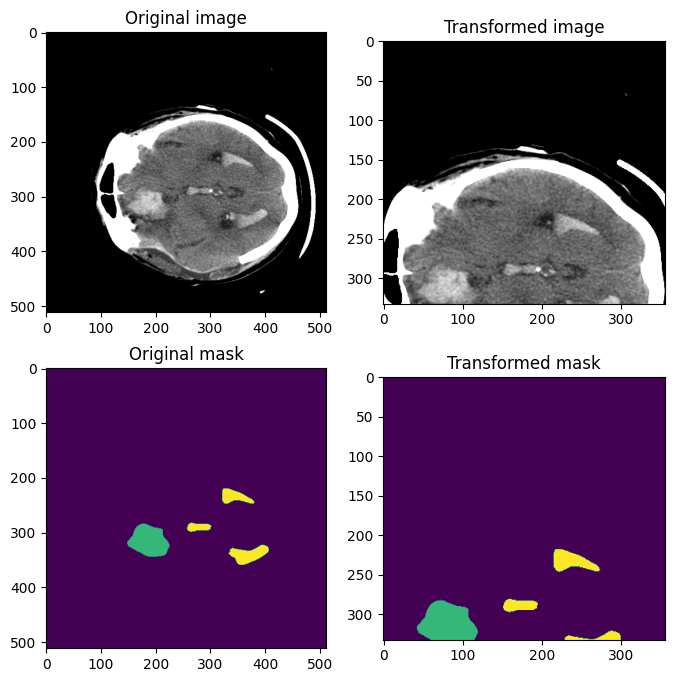

In [19]:
print_info(aug_datas[0])
visualize(data, aug_datas[0])

## CropForeground

`CropForegroundd` 用于根据指定的前景区域裁剪图像及其对应的标签等数据。其本质是在空间维度上将图像缩小到仅包含前景的区域

### 使用场景 


- 病灶区域占比较小，用全图训练模型会浪费资源且影响模型专注目标区域

### 参数解析 

| 参数名          | 类型             | 默认值          | 说明                                                         |
| --------------- | ---------------- | --------------- | ------------------------------------------------------------ |
| keys            | list[str]        | 必填            | 要执行裁剪的字段名列表，如 ["image", "label"]。              |
| source_key      | str              | 无              | 用于识别前景区域的字段，一般为标签，如 "label"。             |
| select_fn       | callable         | lambda x: x > 0 | 前景选择函数，定义哪些像素为前景。                           |
| channel_indices | list[int] / None | None            | 仅在指定通道中寻找前景区域，默认所有通道。                   |
| margin          | int or list[int] | 0               | 在裁剪框周围添加的边缘像素数量，可为单个值或每个维度一个列表。 |
| allow_smaller   | bool             | False           | 图像边界不足时是否允许裁剪框小于设定范围。False 可能导致 padding。 |
| k_divisible     | int or tuple     | 1               | 控制裁剪结果的每个空间维度是否为该值的倍数，用于满足网络结构要求。 |
| mode            | str or list[str] | "constant"      | 填充模式，裁剪区域超出图像边界时使用。支持 numpy 和 PyTorch 的 pad 模式。 |
| start_coord_key | str or None      | None            | 如果设置，则记录裁剪区域的起始坐标，保存在数据中。           |
| end_coord_key   | str or None      | None            | 如果设置，则记录裁剪区域的结束坐标，保存在数据中。           |

image shape: torch.Size([1, 149, 276, 18]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 149, 276, 18]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


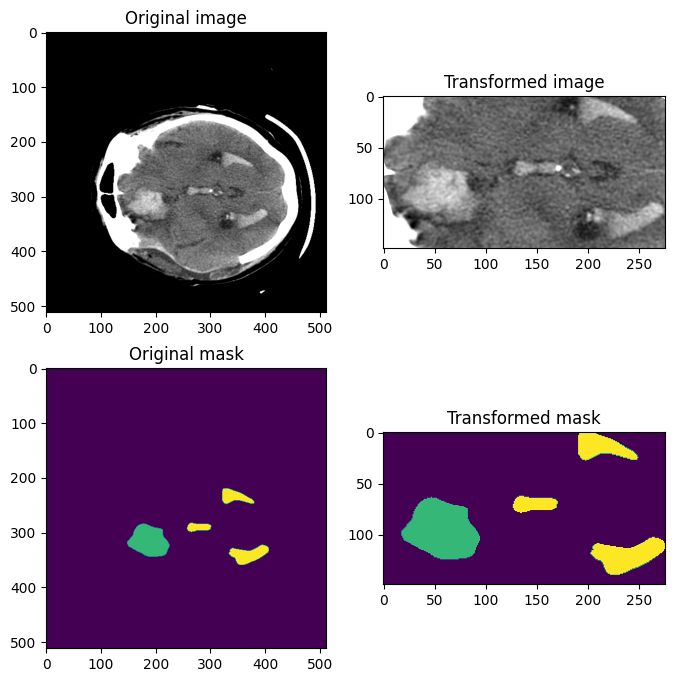

In [25]:
transform = transforms.CropForegroundd(
    keys=["image", "label"],
    source_key="label"
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data, ori_idx=20, aug_idx=6)

## RandCropByPosNegLabel

`RandCropByPosNegLabeld`是一个常用的随机裁剪数据增强变换，特别适用于医学图像分割任务中，对图像和对应标签（mask）进行裁剪。这个变换基于“正负样本”策略，保证裁剪出的子图像包含感兴趣区域（正样本）和背景（负样本），从而提高模型对目标和背景的区分能力。

### 使用场景 


- 医学图像分割训练中，数据增强，增强模型对小目标和背景的识别能力。

### 参数解析 

| 参数名          | 含义与说明                                                   |
| --------------- | ------------------------------------------------------------ |
| keys            | 需要进行裁剪的数据字段名列表。通常是["image", "label"]，指明对哪些数据字段执行裁剪。 |
| label_key       | 标签数据对应的字段名，用来判断哪些位置是前景（感兴趣区域）、哪些是背景，作为裁剪时选择中心点的依据。 |
| spatial_size    | 裁剪patch的空间大小，如[224,224,128]。若某维度指定尺寸大于该维度图像大小，则该维度不会被裁剪，保持原始大小。若某维度为非正值（<=0），则使用标签对应维度大小。示例：输入尺寸为[40,40,40]，spatial_size=[32,64,-1]，输出裁剪尺寸为[32,40,40]。 |
| pos             | 与neg一起决定裁剪中心选择为前景（有标签区域）的概率。比例是pos/(pos+neg)。 |
| neg             | 与pos一起决定裁剪中心选择为背景的概率。比例是neg/(pos+neg)。 |
| num_samples     | 每个样本中裁剪patch的数量，即返回几个裁剪区域。              |
| image_key       | 如果指定，负样本中心点选择时会限制在标签为背景且图像值大于image_threshold的位置，确保负样本裁剪在有效图像区域内。 |
| image_threshold | 用于判断图像有效区域的阈值，配合image_key使用。裁剪负样本时只选择大于该阈值的像素点作为中心。 |
| fg_indices_key  | 预先计算好的前景索引，替代image_key和image_threshold判断，索引应是一维空间位置数组。常结合FgBgToIndicesd变换使用。 |
| bg_indices_key  | 预先计算好的背景索引，同上。                                 |
| allow_smaller   | 如果为False，当图像尺寸小于裁剪尺寸时会抛出异常；为True时，较小维度会不裁剪直接返回原尺寸。 |

In [30]:
transform = transforms.RandCropByPosNegLabeld(
    keys=["image", "label"],
    label_key="label",
    spatial_size=[448, 448, 38],
    pos=5,
    neg=1,
    num_samples=2,
    image_key="image",
    image_threshold=0
)
aug_datas = transform(add_data)
len(aug_datas)

2

image shape: torch.Size([1, 448, 448, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 448, 448, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


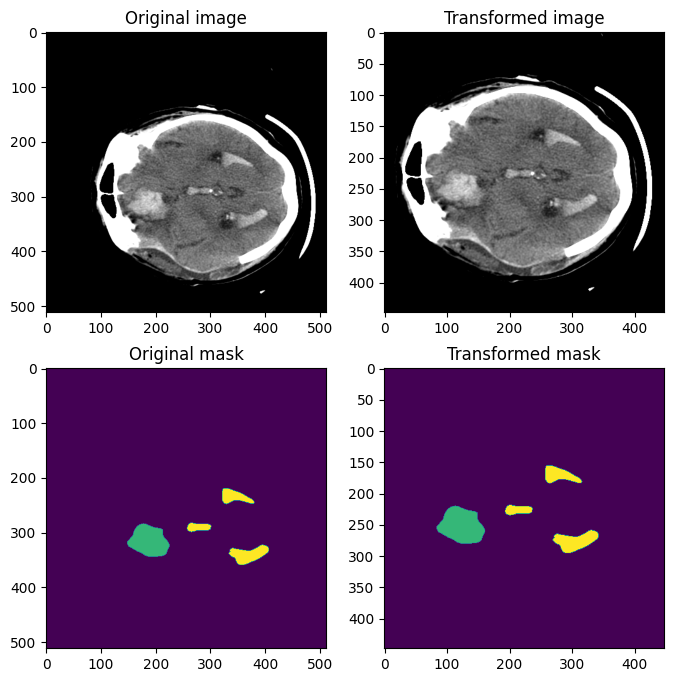

In [31]:
print_info(aug_datas[0])
visualize(data, aug_datas[0])

## RandCropByLabelClasses

`RandCropByLabelClassesd` 主要用于根据标签图中的类（class）随机裁剪图像，使模型能够更好地学习不同类别的区域，尤其是处理类别不均衡问题时非常有用。根据标签图中的不同类别，随机裁剪图像区域，并确保裁剪区域包含特定的类别像素。这样可以使模型更关注感兴趣区域（如肿瘤、小器官等），而不是大片背景。

### 使用场景 


- 医学图像分割中，小器官或病灶区域容易被忽略，通过这种裁剪方式让模型更关注难学区域
- 类别不平衡严重的数据集，提高训练效果

### 参数解析 

| 参数名          | 类型               | 说明                                                         |
| --------------- | ------------------ | ------------------------------------------------------------ |
| keys            | list[str]          | 要应用裁剪的键名列表，如 ["image", "label"]。                |
| label_key       | str                | 标签的键名，用于查找每个类别的位置索引。                     |
| spatial_size    | list[int]          | 裁剪的空间大小，例如 [96, 96, 96]。支持负数（表示保持原尺寸）。 |
| ratios          | list[float] / None | 每个类别用于生成裁剪中心的采样比率（包含背景类）。为 None 时类别等概率采样。 |
| num_classes     | int / None         | 类别数，用于非 one-hot 标签。如果是 one-hot 编码，则不需要设置。 |
| num_samples     | int                | 每次返回的裁剪块数量。                                       |
| image_key       | str / None         | （可选）用于筛选图像中有效区域的键名，仅采样 image > image_threshold 的区域。 |
| image_threshold | float              | （搭配 image_key）阈值，图像中大于该值的区域才会用于采样。   |
| indices_key     | str / None         | （可选）预先计算好的类别索引键名，可加速采样，常搭配 ClassesToIndices 使用。 |
| allow_smaller   | bool               | 如果为 True，图像尺寸小于 spatial_size 时也允许执行，小维度保持不变。 |

In [34]:
transform = transforms.RandCropByLabelClassesd(
    keys=["image", "label"],
    label_key="label",
    spatial_size=(448, 448, -1),
    ratios=(0.2, 0, 0.2, 0.2, 0, 0),
    num_classes=6,
    num_samples=2
)
aug_datas = transform(add_data)
len(aug_datas)

2

image shape: torch.Size([1, 448, 448, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 448, 448, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


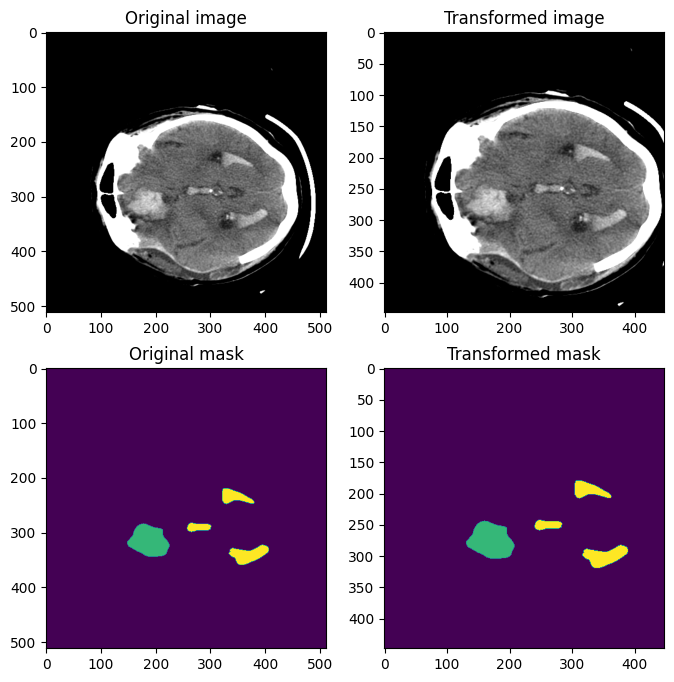

In [37]:
print_info(aug_datas[0])
visualize(data, aug_datas[0])

## ResizeWithPadOrCrop

`ResizeWithPadOrCropd` 是将图像和标签（如掩码）调整到目标大小，可以通过“裁剪”或“填充”的方式来实现。

### 使用场景 


- 模型输入必须是固定大小的情况

### 参数解析 

| 参数名             | 类型                      | 默认值      | 说明                                                         |
| ------------------ | ------------------------- | ----------- | ------------------------------------------------------------ |
| keys               | List[str]                 | —           | 要应用变换的数据键，例如 ["image", "label"]。                |
| spatial_size       | Union[Sequence[int], int] | —           | 输出的空间大小（如 (128, 128, 64)）；如果某维为非正数（如 0、-1），则保留原始尺寸。 |
| mode               | Union[str, Sequence[str]] | "constant"  | 填充模式。NumPy 支持 "constant", "edge", "reflect", 等；Torch 支持 "constant", "reflect", "replicate", "circular" 等。 |
| allow_missing_keys | bool                      | False       | 是否允许某些 key 缺失而不报错。设为 True 可跳过缺失的 key。  |
| method             | str ("symmetric" / "end") | "symmetric" | 填充方法："symmetric" 为两边均匀填充，"end" 仅在尾部填充。   |
| pad_kwargs         | dict                      | {}          | 传递给 np.pad 或 torch.nn.functional.pad 的额外参数，例如 {"constant_values": 0} 表示常数填充值为 0。 |

image shape: torch.Size([1, 448, 448, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 448, 448, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


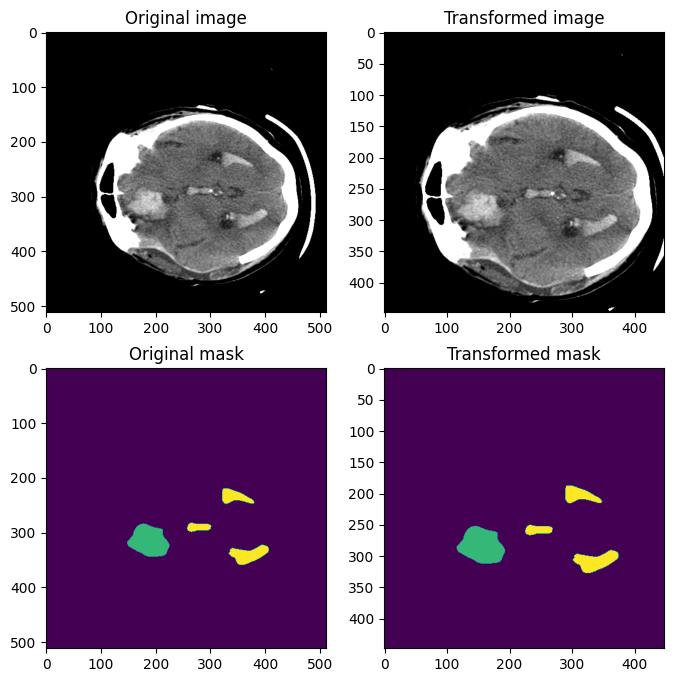

In [38]:
transform = transforms.ResizeWithPadOrCropd(
    keys=["image", "label"],
    spatial_size=[448, 448, 38]
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)